In [6]:
!pip install haystack-ai
!pip install "datasets>=2.6.1"
!pip install "sentence-transformers>=3.0.0"
!pip install ollama-haystack

In [7]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("vblagoje/PubMedQA_instruction", split="train")
dataset = dataset.select(range(1000))
all_documents = [Document(content=doc["context"]) for doc in dataset]
all_questions = [doc["instruction"] for doc in dataset]
all_ground_truth_answers = [doc["response"] for doc in dataset]

In [8]:
from typing import List
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

document_store = InMemoryDocumentStore()

document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

indexing = Pipeline()
indexing.add_component(instance=document_embedder, name="document_embedder")
indexing.add_component(instance=document_writer, name="document_writer")

indexing.connect("document_embedder.documents", "document_writer.documents")

indexing.run({"document_embedder": {"documents": all_documents}})

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 1000}}

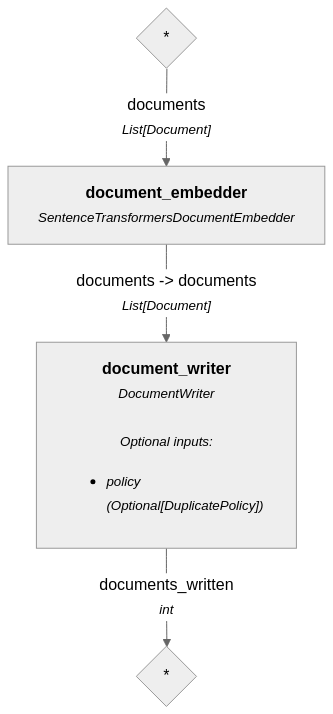

In [9]:
indexing.show()

In [36]:
import os
from getpass import getpass

os.environ['GROQ_API_KEY']=getpass('GROQ_API_KEY: ')

GROQ_API_KEY: ··········


In [39]:
import os
from getpass import getpass
from haystack.utils import Secret
from haystack.components.builders import AnswerBuilder, ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

template = [
    ChatMessage.from_user(
        """
        You have to answer the following question based on the given context information only.

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """
    )
]


llm = OpenAIGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="deepseek-r1-distill-qwen-32b"
)

rag_pipeline = Pipeline()
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
)
rag_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(template=template))
rag_pipeline.add_component("generator", generator)
rag_pipeline.add_component("answer_builder", AnswerBuilder())

rag_pipeline.connect("query_embedder", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "generator.messages")
rag_pipeline.connect("generator.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")

PipelineError: Component has already been added in another Pipeline. Components can't be shared between Pipelines. Create a new instance instead.

In [32]:
question = "Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?"

response = rag_pipeline.run(
    {
        "query_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question},
    }
)
print(response["answer_builder"]["answers"][0].data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ReadTimeout: The read operation timed out

In [ ]:
import random

questions, ground_truth_answers, ground_truth_docs = zip(
    *random.sample(list(zip(all_questions, all_ground_truth_answers, all_documents)), 25)
)

In [ ]:
rag_answers = []
retrieved_docs = []

for question in list(questions):
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer from pipeline:")
    print(response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")

    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

While each evaluator is a component that can be run individually in Haystack, they can also be added into a pipeline. This way, we can construct an `eval_pipeline` that includes all evaluators for the metrics we want to evaluate our pipeline on.

In [ ]:
from haystack.components.evaluators.document_mrr import DocumentMRREvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("doc_mrr_evaluator", DocumentMRREvaluator())
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator())
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2"))

results = eval_pipeline.run(
    {
        "doc_mrr_evaluator": {
            "ground_truth_documents": list([d] for d in ground_truth_docs),
            "retrieved_documents": retrieved_docs,
        },
        "faithfulness": {
            "questions": list(questions),
            "contexts": list([d.content] for d in ground_truth_docs),
            "predicted_answers": rag_answers,
        },
        "sas_evaluator": {"predicted_answers": rag_answers, "ground_truth_answers": list(ground_truth_answers)},
    }
)

### Constructing an Evaluation Report

Once we've run our evaluation pipeline, we can also create a full evaluation report. Haystack provides an `EvaluationRunResult` which we can use to display an `aggregated_report` 👇

In [ ]:
from haystack.evaluation.eval_run_result import EvaluationRunResult

inputs = {
    "question": list(questions),
    "contexts": list([d.content] for d in ground_truth_docs),
    "answer": list(ground_truth_answers),
    "predicted_answer": rag_answers,
}

evaluation_result = EvaluationRunResult(run_name="pubmed_rag_pipeline", inputs=inputs, results=results)
evaluation_result.aggregated_report()

{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [1.0, np.float64(1.0), np.float64(0.731985309123993)]}

#### Extra: You can also see a detailed report with the scores for each sample in your dataset, and we will choose the output format as DataFrame

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Does increased Syk phosphorylation lead to ove...,[Activation of B cells is a hallmark of system...,Our results suggest that the activated Syk-med...,"Yes, increased Syk phosphorylation is associat...",1.0,1.0,0.737820
1,Do rotavirus vaccines contribute towards unive...,[To evaluate rotavirus vaccination in Malaysia...,We propose that universal vaccination compleme...,"Yes, rotavirus vaccines contribute towards uni...",1.0,1.0,0.597597
2,Are hospitalisation costs for infant bronchiol...,[Up to 3% of infants with bronchiolitis under ...,The hospitalisation costs of infants treated i...,"Yes, the hospitalisation costs for infant bron...",1.0,1.0,0.843995
3,Does severe nutritional risk predict decreased...,[Weight loss and malnutrition are poorly toler...,Severe nutritional risk can be a useful predic...,"Yes, severe nutritional risk predicts decrease...",1.0,1.0,0.747795
4,Is cognitive reserve a determinant of health-r...,[Covert hepatic encephalopathy (CHE) is associ...,A higher cognitive reserve is associated with ...,"Yes, cognitive reserve is a significant determ...",1.0,1.0,0.838117
5,Does the CC-genotype of the cyclooxygenase-2 g...,[The cyclooxygenase-2 (cox-2) pathway is now r...,We conclude that the CC-genotype and C allele ...,"Yes, the CC-genotype of the cyclooxygenase-2 g...",1.0,1.0,0.821029
6,Does preoperative anemia increase postoperativ...,[Preoperative anemia may affect postoperative ...,Preoperative anemia in elective cranial neuros...,"Yes, preoperative anemia increases postoperati...",1.0,1.0,0.909551
7,Does ketamine inhibit proliferation of neural ...,[Ketamine is a widely used anesthetic in obste...,Ketamine inhibited proliferation of NSCs from ...,"Yes, ketamine significantly inhibited the prol...",1.0,1.0,0.749711
8,Does metoclopramide unmask potentially mislead...,[As metoclopramide stimulates aldosterone secr...,Metoclopramide does not enhance lateralization...,"Yes, metoclopramide can unmask potentially mis...",1.0,1.0,0.728780
9,Is persistent arm pain distinct from persisten...,[Persistent pain following breast cancer surge...,"For persistent breast and arm pain, changes in...","Yes, persistent arm pain is distinct from pers...",1.0,1.0,0.904209


Having our evaluation results as a dataframe can be quite useful. For example, below we can use the pandas dataframe to filter the results to the top 3 best scores for semantic answer similarity (`sas_evaluator`) as well as the bottom 3 👇


In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
21,Does nAIF1 inhibit gastric cancer cells migrat...,[Nuclear apoptosis-inducing factor 1 (NAIF1) c...,Our study revealed that NAIF1 plays a role in ...,"Yes, NAIF1 inhibits gastric cancer cells migra...",1.0,1.0,0.867813
5,Are [ Higher nitric oxide levels associated wi...,[Oxidative stress generated within inflammator...,There are increased levels of nitric oxide in ...,"Yes, higher nitric oxide levels are associated...",1.0,1.0,0.853290
15,Is loss of N-cadherin associated with loss of ...,[Our previous study suggested that N-cadherin ...,Loss of N-cadherin was positively correlated w...,"Yes, loss of N-cadherin is associated with los...",1.0,1.0,0.844145
19,Is malonate as a ROS product associated with p...,[The role of anaplerotic nutrient entry into t...,This study extends the interest in the PC acti...,"Yes, malonate is associated with pyruvate carb...",1.0,1.0,0.472158
10,Is depression a consistent syndrome : An inves...,[The DSM-5 encompasses a wide range of symptom...,Symptoms were dichotomized to construct sympto...,"Depression is not a consistent syndrome, as th...",1.0,1.0,0.534966
24,Does brivaracetam differentially affect voltag...,[Brivaracetam (BRV) is an antiepileptic drug i...,The lack of effect of BRV on SRF in neurons su...,"Yes, brivaracetam differentially affects volta...",1.0,1.0,0.551872


In [27]:
from haystack_integrations.components.generators.ollama import OllamaChatGenerator

generator = OllamaChatGenerator(model="deepseek-r1:1.5b", url="https://great-termite-43.loca.lt")

In [28]:
generator

Inputs:
  - messages: List[ChatMessage]
  - generation_kwargs: Optional[Dict[str, Any]]
  - tools: Optional[List[Tool]]
Outputs:
  - replies: List[ChatMessage]

In [30]:
output = generator.run([ChatMessage.from_user("how many r's are there in the strawberry?")])
print(output)


{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='<think>\nTo determine how many \'r\'s are in the word "strawberry," I first need to write out the spelling of that word.\n\nNext, I\'ll go through each letter one by one and check if it is an \'r.\'\n\nAfter carefully examining each letter, I count the number of times the letter \'r\' appears.\n\nFinally, I will provide the total count as the answer.\n</think>\n\nTo determine how many **"r"s** are in the word "strawberry," let\'s break down the spelling and examine each character:\n\n1. **S**\n2. **t**\n3. **w**\n4. **a**\n5. **n**\n6. **a**\n7. **u**\n8. **f**\n9. **o**\n10. **r** (First "r")\n11. **b**\n12. **e**\n13. **r** (Second "r")\n\nAfter carefully reviewing each letter, we can see that there are **2** instances of the letter **"r"** in the word "strawberry."\n\n\\[\n\\boxed{2}\n\\]')], _name=None, _meta={'model': 'deepseek-r1:1.5b', 'created_at': '2025-03-22T09:16:14.41484718Z', 'don

In [33]:
from haystack.components.generators.chat import OpenAIChatGenerator

In [35]:
help(OpenAIChatGenerator)

Help on class OpenAIChatGenerator in module haystack.components.generators.chat.openai:

class OpenAIChatGenerator(builtins.object)
 |  OpenAIChatGenerator(*args, **kwargs)
 |  
 |  Completes chats using OpenAI's large language models (LLMs).
 |  
 |  It works with the gpt-4 and gpt-3.5-turbo models and supports streaming responses
 |  from OpenAI API. It uses [ChatMessage](https://docs.haystack.deepset.ai/docs/chatmessage)
 |  format in input and output.
 |  
 |  You can customize how the text is generated by passing parameters to the
 |  OpenAI API. Use the `**generation_kwargs` argument when you initialize
 |  the component or when you run it. Any parameter that works with
 |  `openai.ChatCompletion.create` will work here too.
 |  
 |  For details on OpenAI API parameters, see
 |  [OpenAI documentation](https://platform.openai.com/docs/api-reference/chat).
 |  
 |  ### Usage example
 |  
 |  ```python
 |  from haystack.components.generators.chat import OpenAIChatGenerator
 |  from h